# DL1 Assignment2 - Q1.1 draft code

This is a small help from us to save you some coding. This notebook is **not** graded, you are free to edit it.

Further advise:
1. Start with File/Save a copy in Drive
2. Set GPU usage under Runtime/Change runtime type/Hardware accelerator.

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import timm
from torchvision import models
from matplotlib import pyplot as plt
from typing import Callable

%matplotlib inline

In [ ]:
def vit_s_8():
    """ViT-S/8 is not a default torchvision model, so we provide it by timm"""
    # Accuracy approximation comes from
    # https://openreview.net/pdf?id=LtKcMgGOeLt
    # and DINO
    # https://arxiv.org/abs/2104.14294
    return timm.create_model('vit_small_patch8_224')

# Model definitions
# Optional Q: These are uncalled functions. What do you think would happen
# if we called all of them once? Why didn't we do that?
model_defs = [
    vit_s_8,
    models.vit_b_32,
    models.vgg11,
    models.vgg11_bn,
    models.resnet18,
    models.densenet121,
    models.mobilenet_v3_small,
]

# Accuracies per model
model_accs = {
    'vit_s_8': 80., # Approximated
    'vit_b_32' : 75.912,
    'vgg11' : 69.02,
    'vgg11_bn' : 70.37,
    'resnet18' : 69.758,
    'densenet121' : 74.434,
    'mobilenet_v3_small' : 67.668,
}


def measure_runtime_per_forward(model:nn.Module, no_grad:bool, batch_size:int=8):
    """Measures the time for a single pass in milliseconds"""

    # Generate fake RGB input (224x224)
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input = torch.rand((batch_size, 3, 224, 224)).to(device)
    #######################
    # END OF YOUR CODE    #
    #######################

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    # Run the model
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    model.to(device)

    output = []

    if no_grad:
      with torch.no_grad():
        output.append(model(input))
    else:
      output.append(model(input))
    #######################
    # END OF YOUR CODE    #
    #######################

    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end)


def evaluate_model(model_def:Callable, no_grad:bool, batch_size:int=8):

    # Retreive initial memory allocation
    initial_vram = torch.cuda.memory_allocated()

    # Define model
    model = model_def().cuda().eval()
    # Access name as: model.__name__

    # Parameters that need to be filled
    n_params = None
    times, vrams = [], []
    mean_time = None
    mean_vram = None

    #######################
    # PUT YOUR CODE HERE  #
    #######################

    # Step 1: Calculate the number of **trainable** parameters
    # Step 2: Warm up with a few passes
    # Step 3: Run N forward passes and save the runtime +
    #         the vram allocated by the model
    # Step 4: Take the mean, preferably with dropping possible outliers
    model = model_def()
    n_params = sum(param.numel() for param in model.parameters() if param.requires_grad)

    N = 20
    for _ in range(N):
      times.append(measure_runtime_per_forward(model, no_grad, batch_size))
      vrams.append(torch.cuda.memory_allocated() - initial_vram)

    mean_time = torch.tensor(times, dtype=torch.float32).mean().item()
    mean_vram = torch.tensor(vrams, dtype=torch.float32).mean().item() * 1e-6
    #######################
    # END OF YOUR CODE    #
    #######################

    # Clean up space for the model
    del model
    torch.cuda.empty_cache()

    return mean_time, mean_vram, n_params


Plots with no_grad=True
vit_s_8 22.18295669555664 87.088128 21670272
vit_b_32 14.490438461303711 353.224704 88224232
vgg11 14.61235523223877 531.781632 132863336
vgg11_bn 16.71988296508789 531.830784 132868840
resnet18 5.228318214416504 47.516672 11689512
densenet121 26.160037994384766 32.357887999999996 7978856
mobilenet_v3_small 9.04487133026123 10.281471999999999 2542856


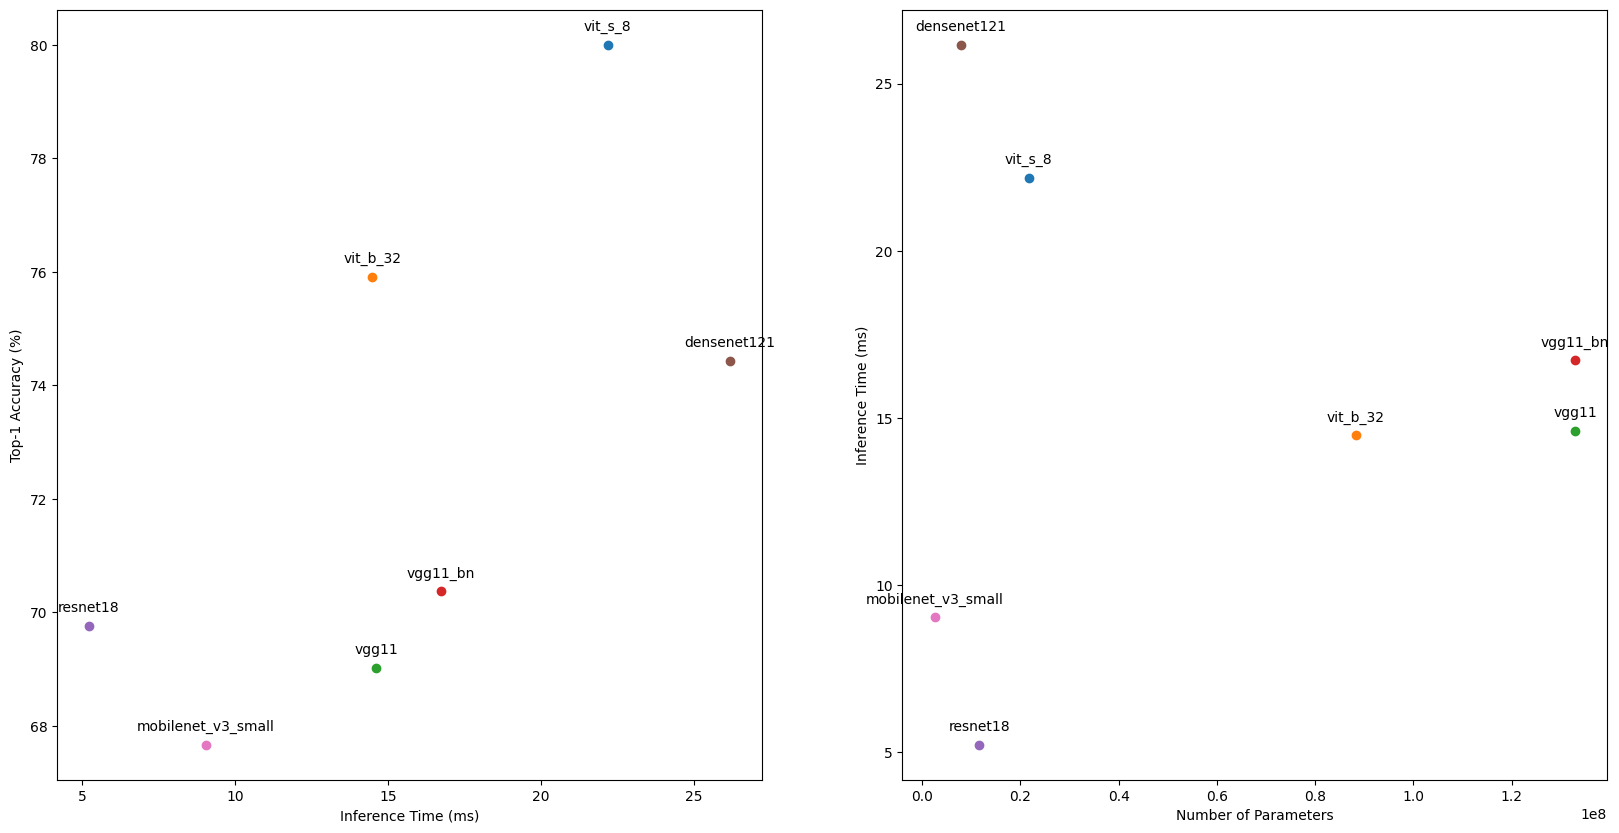

Plots with no_grad=False
vit_s_8 20.834688186645508 99.02971199999999 21670272
vit_b_32 16.146772384643555 353.224704 88224232
vgg11 15.988194465637207 531.781632 132863336
vgg11_bn 15.533650398254395 531.830784 132868840
resnet18 5.409993648529053 47.516672 11689512
densenet121 29.71512794494629 32.357887999999996 7978856
mobilenet_v3_small 10.543971061706543 10.281471999999999 2542856


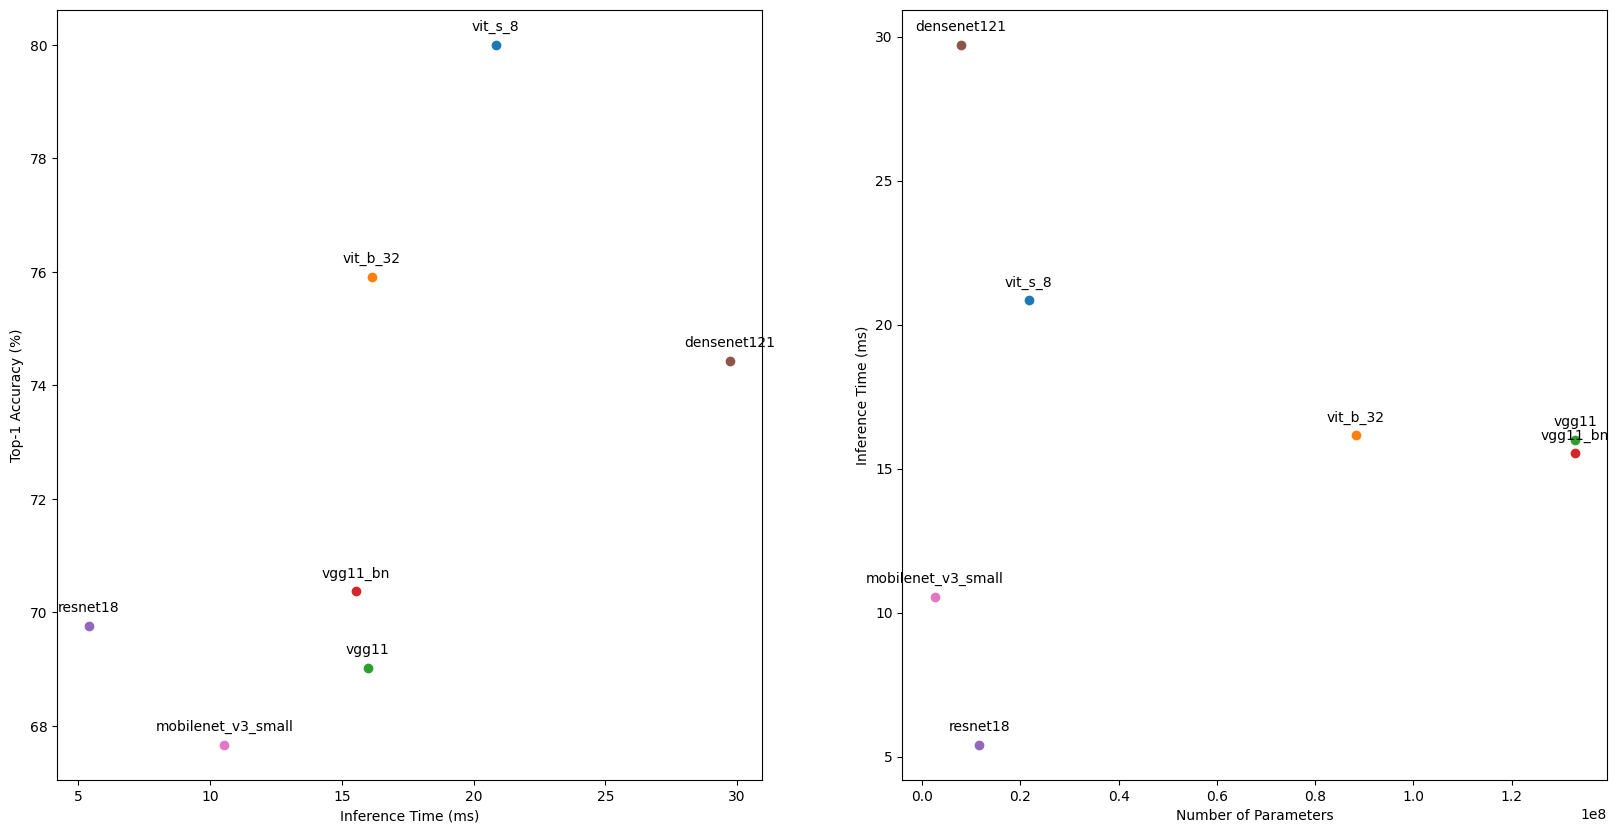

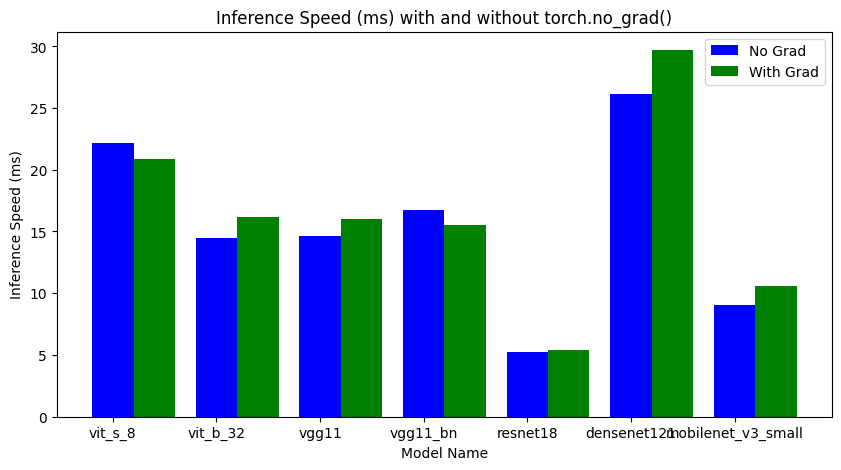

Plots with no_grad=True
vit_s_8 920.5647583007812 150.65743999999998 21670272
vit_b_32 172.66700744628906 357.10380799999996 88224232
vgg11 152.8800506591797 533.721184 132863336
vgg11_bn 183.13088989257812 535.709888 132868840
resnet18 51.888465881347656 47.320063999999995 11689512
densenet121 212.87545776367188 36.237004 7978856
mobilenet_v3_small 17.53760528564453 12.221029999999999 2542856


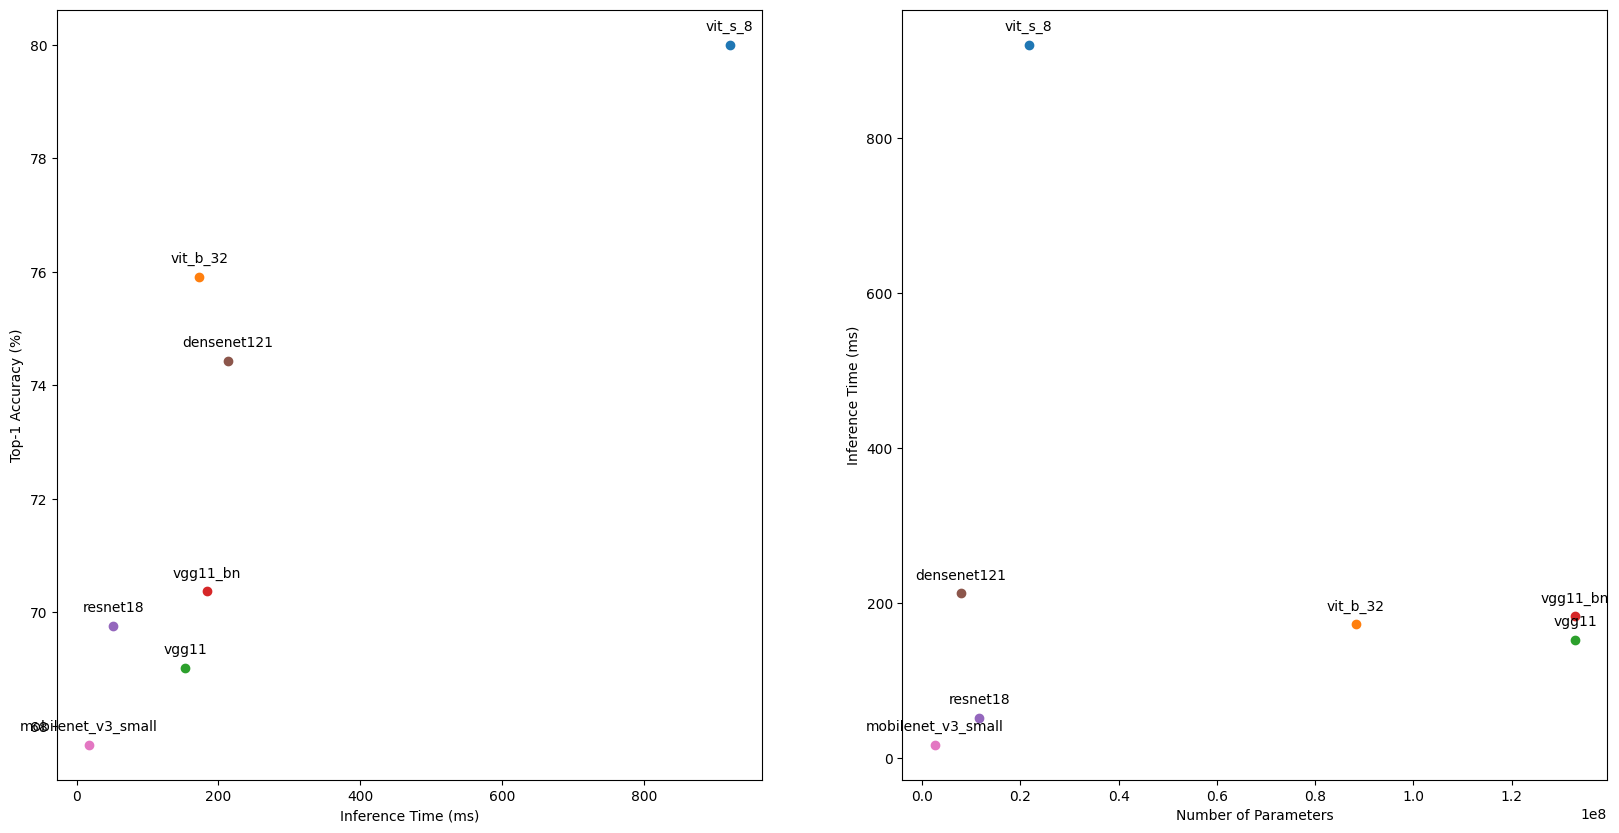

Plots with no_grad=False
vit_s_8 996.7138671875 6111.209472 21670272
vit_b_32 180.46926879882812 457.19647999999995 88224232
vgg11 152.51522827148438 1157.229824 132863336
vgg11_bn 182.25225830078125 783.24736 132868840
resnet18 51.099693298339844 47.320063999999995 11689512
densenet121 211.1946563720703 450.769568 7978856
mobilenet_v3_small 21.74464988708496 10.281471999999999 2542856


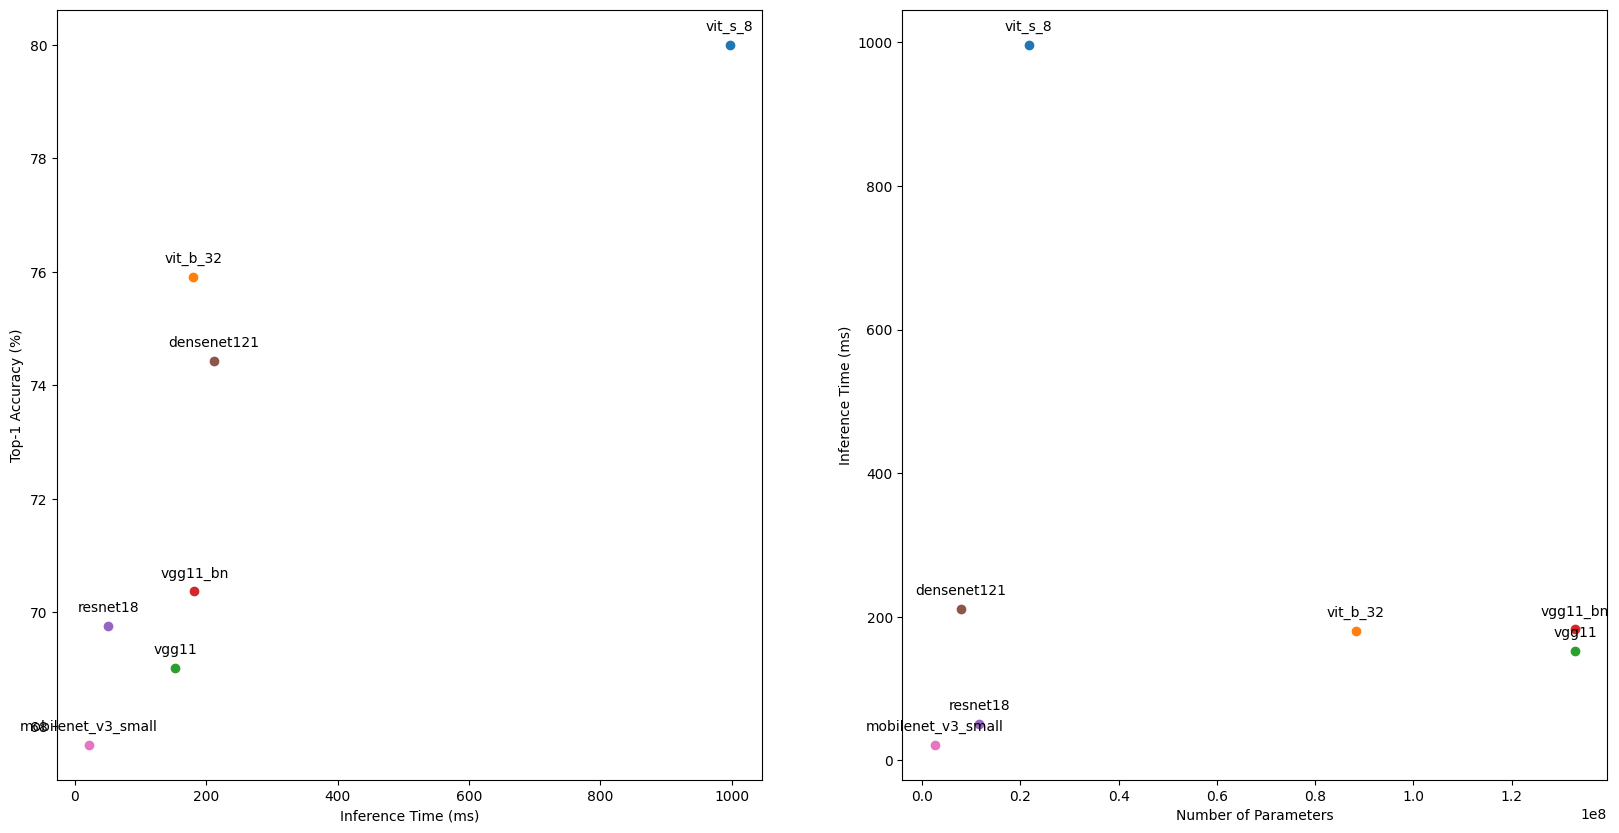

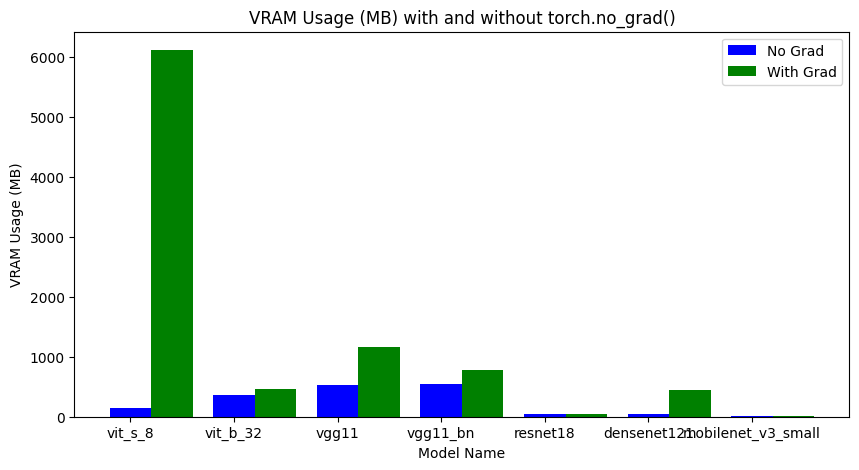

In [ ]:
#######################
# PUT YOUR CODE HERE  #
#######################

# Make your plots here with matplotlib
#
# Example usage of the above functions:
def create_plots(no_grad, batch_size=8):
  fig, axs = plt.subplots(1, 2, figsize=(20,10))
  axs[0].set_xlabel("Inference Time (ms)")
  axs[0].set_ylabel("Top-1 Accuracy (%)")

  axs[1].set_ylabel("Inference Time (ms)")
  axs[1].set_xlabel("Number of Parameters")

  names, times, vrams = [], [], []

  for model_def in model_defs:
      name = model_def.__name__
      time, vram, n_params = evaluate_model(model_def, no_grad=no_grad, batch_size=batch_size)
      times.append(time)
      vrams.append(vram)
      names.append(name)

      acc_point = (time, model_accs[name])
      axs[0].scatter(*acc_point)
      axs[0].annotate(name, acc_point, textcoords="offset points", xytext=(0,10), ha='center')

      param_point = (n_params, time)
      axs[1].scatter(*param_point)
      axs[1].annotate(name, param_point, textcoords="offset points", xytext=(0,10), ha='center')

      print(name, time, vram, n_params)

  plt.show()

  return names, times, vrams



def bar_plot(model_names, data_no_grad, data_grad, data_label):
  plt.figure(figsize=(10, 5))
  plt.bar(range(len(model_names)), data_no_grad, width=0.4, label='No Grad', align='center', color='b')
  plt.bar([i + 0.4 for i in range(len(model_names))], data_grad, width=0.4, label='With Grad', align='center', color='g')
  plt.xlabel('Model Name')
  plt.ylabel(data_label)
  plt.title(data_label + ' with and without torch.no_grad()')
  plt.xticks(range(len(model_names)), model_names)
  plt.legend()
  plt.show()


print('Plots with no_grad=True')
model_names, times_no_grad, _ = create_plots(no_grad=True, batch_size=1)

print('Plots with no_grad=False')
_, times_with_grad, _ = create_plots(no_grad=False, batch_size=1)

bar_plot(model_names, times_no_grad, times_with_grad, 'Inference Speed (ms)')

print('Plots with no_grad=True')
model_names, _, vrams_no_grad = create_plots(no_grad=True, batch_size=64)

print('Plots with no_grad=False')
_, _, vrams_with_grad = create_plots(no_grad=False, batch_size=64)
bar_plot(model_names, vrams_no_grad, vrams_with_grad, 'VRAM Usage (MB)')

#######################
# END OF YOUR CODE    #
#######################

In [ ]:
_